In [2]:
!pip install torch torchvision torchaudio
!pip install scikit-learn pandas matplotlib

importing libraries



In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


loading the dataset

In [5]:


# Replace with your uploaded filename
df = pd.read_csv("sales_data.csv")

# Show first rows
df.head()


,Date,Sales,Lag_1,Lag_7,Lag_30,DayOfWeek,Month,Year
0,2021-01-06,275,280,240,250,4,1,2021
1,2021-01-07,290,275,250,260,5,1,2021
2,2021-01-08,310,290,270,280,6,1,2021
3,2021-01-09,330,310,290,300,0,1,2021
4,2021-01-10,340,330,310,320,1,1,2021


preprocessing data

In [6]:
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Features (exclude 'Date' and 'Sales')
X = df.drop(['Date', 'Sales'], axis=1).values
y = df['Sales'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


neural network model

In [7]:
class SalesPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, activation_fn):
        super(SalesPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = activation_fn
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        return self.fc2(x)


train and evaluvate functions

In [8]:
def train_and_evaluate(X_train, y_train, X_test, y_test, hidden_size, lr, activation_fn, epochs=100, batch_size=32):
    input_size = X_train.shape[1]
    model = SalesPredictor(input_size, hidden_size, activation_fn)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(X_train.size()[0])
        for i in range(0, X_train.size()[0], batch_size):
            indices = permutation[i:i+batch_size]
            batch_X, batch_y = X_train[indices], y_train[indices]

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).numpy()
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return model, rmse, predictions


manual tuning


In [13]:
hidden_layers = [8, 16, 32, 64, 128]
learning_rates = [0.001, 0.01, 0.1]
activations = [nn.ReLU(), nn.Tanh(), nn.Sigmoid()]
epochs = [50, 100, 200, 300]

best_rmse = float("inf")
best_model = None
best_params = {}

for hl in hidden_layers:
    for lr in learning_rates:
        for act in activations:
            for ep in epochs:
                print(f"Training: hidden={hl}, lr={lr}, act={act}, epochs={ep}")
                model, rmse, preds = train_and_evaluate(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, hl, lr, act, epochs=ep)

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    best_params = {"hidden_size": hl, "lr": lr, "activation": act, "epochs": ep}
                    torch.save(best_model.state_dict(), "best_sales_model.pth")

print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)


Training: hidden=8, lr=0.001, act=ReLU(), epochs=50
Training: hidden=8, lr=0.001, act=ReLU(), epochs=100
Training: hidden=8, lr=0.001, act=ReLU(), epochs=200
Training: hidden=8, lr=0.001, act=ReLU(), epochs=300
Training: hidden=8, lr=0.001, act=Tanh(), epochs=50
Training: hidden=8, lr=0.001, act=Tanh(), epochs=100
Training: hidden=8, lr=0.001, act=Tanh(), epochs=200
Training: hidden=8, lr=0.001, act=Tanh(), epochs=300
Training: hidden=8, lr=0.001, act=Sigmoid(), epochs=50
Training: hidden=8, lr=0.001, act=Sigmoid(), epochs=100
Training: hidden=8, lr=0.001, act=Sigmoid(), epochs=200
Training: hidden=8, lr=0.001, act=Sigmoid(), epochs=300
Training: hidden=8, lr=0.01, act=ReLU(), epochs=50
Training: hidden=8, lr=0.01, act=ReLU(), epochs=100
Training: hidden=8, lr=0.01, act=ReLU(), epochs=200
Training: hidden=8, lr=0.01, act=ReLU(), epochs=300
Training: hidden=8, lr=0.01, act=Tanh(), epochs=50
Training: hidden=8, lr=0.01, act=Tanh(), epochs=100
Training: hidden=8, lr=0.01, act=Tanh(), epoc

predictions graph output

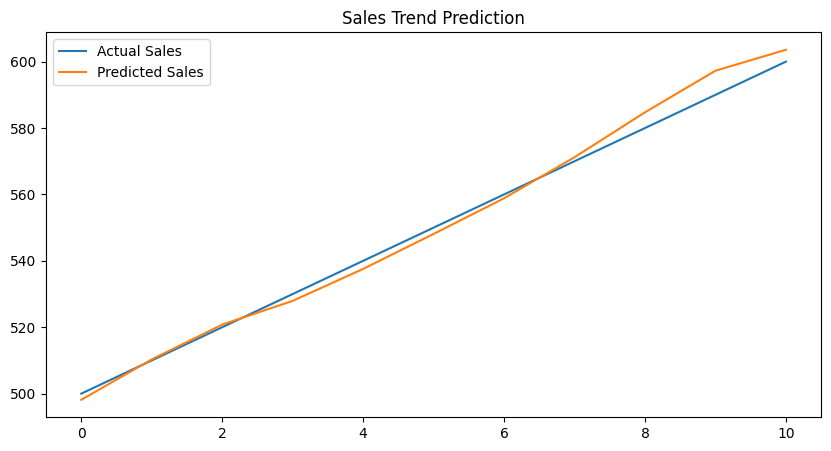

In [14]:
# Load best model
input_size = X_train.shape[1]
loaded_model = SalesPredictor(input_size, best_params["hidden_size"], best_params["activation"])
loaded_model.load_state_dict(torch.load("best_sales_model.pth"))
loaded_model.eval()

with torch.no_grad():
    predictions = loaded_model(X_test_tensor).numpy()

# Plot
plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual Sales")
plt.plot(predictions, label="Predicted Sales")
plt.legend()
plt.title("Sales Trend Prediction")
plt.show()
